In [1]:
from pandas import CategoricalDtype, read_csv
import pandas as pd

# -------------------------
# 1. 설정 정의
# -------------------------

# CSV key 목록
RE_KEYS = ('DE', 'DR', 'V')

# 기본 숫자 변환기
parse_int = lambda x: int(x) if x else 0
parse_int_comma = lambda x: int(x.replace(',', '')) if x else 0

# CSV 컬럼별 변환 함수
CONVERTERS = {
    'T': lambda x: int(x) if x else 1,
    'R': lambda x: x if x else 'A',
    'E': parse_int,
    'A': parse_int,
    'DE': parse_int,
    'DA': parse_int_comma,
    'H': parse_int_comma,
    'M': parse_int_comma,
}

# 컬럼별 dtype
DTYPES = {
    'T': CategoricalDtype((1, 2)),
    'R': CategoricalDtype(('A', 'T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'DE': 'uint8',
    'DA': 'uint16',
    'H': 'uint16',
    'M': 'uint16'
}


# -------------------------
# 2. CSV 데이터 읽기 & 병합
# -------------------------

def load_re_data():
    df_list = []
    for key in RE_KEYS:
        df = read_csv(f'R/{key}.csv', index_col=0, converters=CONVERTERS)
        df = df.astype(DTYPES, copy=False)
        df_list.append(df)
    return pd.concat(df_list, keys=RE_KEYS, names=('RE',))


df = load_re_data()
df

T  R   E  A  DE    DA     H     M
RE I                                     
DE 1    1  T   0  0   8  2947  1425  4611
   1    1  D   1  0   3  1818     0   650
   1    1  D   2  0   7  4735   487   308
   1    1  S   1  0   3  2078  2748     0
   1    1  S   1  1   3   269  5848   189
...    .. ..  .. ..  ..   ...   ...   ...
V  467  2  T   7  2   4  6453     0  9665
   467  2  D  10  0   5  6272    62  1417
   467  2  D   6  1   7  5267    78    76
   467  2  S   5  1   6  4602  8211   716
   467  2  S   2  5   7  1979  7396   329

[9110 rows x 8 columns]

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   T       9110 non-null   category
 1   R       9110 non-null   category
 2   E       9110 non-null   uint8   
 3   A       9110 non-null   uint8   
 4   DE      9110 non-null   uint8   
 5   DA      9110 non-null   uint16  
 6   H       9110 non-null   uint16  
 7   M       9110 non-null   uint16  
dtypes: category(2), uint16(3), uint8(3)
memory usage: 144.9+ KB


In [3]:
from numpy import float32

values = df.iloc[:, 2:].to_numpy()
max_vals = values.max(axis=0)
normalized = (values / max_vals).astype(float32, copy=False)
normalized

array([[0.        , 0.        , 0.3478261 , 0.0984894 , 0.05393845,
        0.13442756],
       [0.01754386, 0.        , 0.13043478, 0.06075797, 0.        ,
        0.01894988],
       [0.03508772, 0.        , 0.3043478 , 0.15824477, 0.0184337 ,
        0.00897933],
       ...,
       [0.10526316, 0.01612903, 0.3043478 , 0.17602433, 0.00295242,
        0.00221568],
       [0.0877193 , 0.01612903, 0.26086956, 0.15379988, 0.31079903,
        0.02087403],
       [0.03508772, 0.08064516, 0.3043478 , 0.06613863, 0.27995002,
        0.00959156]], dtype=float32)

In [4]:
# 전체 컬럼(열) 개수 구하기
num_cols = normalized.shape[1]

# Reshape 과정:
# - normalized 배열을 10행씩 묶어서 하나의 긴 행으로 재구성
#   → reshape(-1, num_cols * 10)은 총 행 수를 10개 단위로 묶어 새로운 행으로 만든다는 의미
# - 이후 .T로 전치(transpose)하여 행/열을 뒤집음
# - 마지막으로 tuple(...)로 변환해 튜플 형태로 저장
reshaped_tuple = tuple(
    normalized.reshape(-1, num_cols * 10).T
)
len(reshaped_tuple)

60

2025-11-22 05:57:04.423999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763791024.438332    1179 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763791024.442548    1179 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763791024.456097    1179 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763791024.456112    1179 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763791024.456114    1179 computation_placer.cc:177] computation placer alr

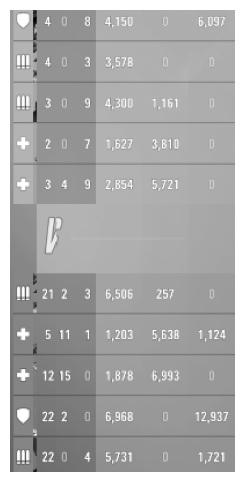

[[    4     0     8  4150     0  6097]
 [    4     0     3  3578     0     0]
 [    3     0     9  4300  1161     0]
 [    2     0     7  1627  3810     0]
 [    3     4     9  2854  5721     0]
 [   21     2     3  6506   257     0]
 [    5    11     1  1203  5638  1124]
 [   12    15     0  1878  6993     0]
 [   22     2     0  6968     0 12937]
 [   22     0     4  5731     0  1721]]


2025-11-22 05:57:11.671513: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
from pathlib import Path
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show
from numpy import array, uint16


# ==========================
# 이미지 전처리 함수
# ==========================

def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, (400, 194)) / 255
    return resized, label


# ==========================
# Dataset 생성
# ==========================

image_paths = sorted(map(str, Path().rglob('*.png')))
data_count = len(reshaped_tuple)

dataset = (
    Dataset.from_tensor_slices((image_paths, reshaped_tuple))
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(data_count)
)

train_size = int(data_count * 0.9)
train_ds = dataset.take(train_size).batch(32).prefetch(AUTOTUNE)
val_ds = dataset.skip(train_size).batch(32).prefetch(AUTOTUNE)

# ==========================
# 샘플 시각화
# ==========================

for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print((array(y_batch).T[0].reshape(-1, num_cols) * max_vals).round().astype(uint16))

In [8]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import Huber

clear_session()

# ==========================
# CNN 백본 모델 정의
# ==========================

input_tensor = Input(shape=x_batch.shape[1:])

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(256, use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(.4)(x)

# ==========================
# 다중 출력층 생성
# ==========================

numeric_cols = df.columns.to_list()[2:]
outputs = []
for i in range(10):
    for col in numeric_cols:
        outputs.append(Dense(1, name=f'{col}_{i}')(x))
model = Model(inputs=input_tensor, outputs=outputs)

# ==========================
# 모델 컴파일
# ==========================

loss = {}
for i in range(10):
    for col in numeric_cols:
        loss[f'{col}_{i}'] = Huber()
metrics = {}
for i in range(10):
    for col in numeric_cols:
        metrics[f'{col}_{i}'] = 'mean_absolute_error'
model.compile('adamw', loss, metrics=metrics)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 194,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 400, 194,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 400, 194,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 400, 194,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 200, 97,   │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 97,   │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 97,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 200, 97,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 100, 48,   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 48,   │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 48,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 100, 48,   │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 24,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 153600)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 39,321,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ re_lu_3[0][0]   

 Total params: 39,431,388 (150.42 MB)

 Trainable params: 39,430,428 (150.42 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
from tensorflow.keras.callbacks import Callback, EarlyStopping


class MetricSummaryCallback(Callback):
    def __init__(self, metric_groups=numeric_cols):
        super().__init__()
        self.metric_groups = metric_groups

    def on_train_begin(self, logs=None):
        self.total_epochs = self.params.get('epochs', None)

    def on_epoch_end(self, epoch, logs=None):
        epoch_num = epoch + 1
        total_epochs = self.total_epochs or '?'
        print(f'{epoch_num}/{total_epochs}')

        for group in self.metric_groups:
            # 관련 로그 필터링
            related_logs = {
                key: value for key, value in logs.items()
                if key.startswith(f'val_{group}')
            }

            # accuracy 계산
            acc_values = [
                v for k, v in related_logs.items() if k.endswith('_mean_absolute_error')
            ]
            avg_acc = sum(acc_values) / len(acc_values) if acc_values else None

            # loss 계산
            loss_values = [
                v for k, v in related_logs.items() if k.endswith('_loss')
            ]
            avg_loss = sum(loss_values) / len(loss_values) if loss_values else None

            print(
                f'- {group} '
                f'- val_mean_absolute_error: {avg_acc:.4f} '
                f'- val_loss: {avg_loss:.4f}'
            )


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

# 학습
history = model.fit(
    train_ds,
    epochs=256,
    verbose=0,
    callbacks=(MetricSummaryCallback(), early_stop),
    validation_data=val_ds
)

1/256
- E - val_mean_absolute_error: 0.1763 - val_loss: 0.0242
- A - val_mean_absolute_error: 0.1268 - val_loss: 0.0122
- DE - val_mean_absolute_error: 0.1647 - val_loss: 0.0218
- DA - val_mean_absolute_error: 0.1690 - val_loss: 0.0237
- H - val_mean_absolute_error: 0.1212 - val_loss: 0.0152
- M - val_mean_absolute_error: 0.0909 - val_loss: 0.0091
2/256
- E - val_mean_absolute_error: 0.1641 - val_loss: 0.0213
- A - val_mean_absolute_error: 0.1248 - val_loss: 0.0117
- DE - val_mean_absolute_error: 0.1565 - val_loss: 0.0198
- DA - val_mean_absolute_error: 0.1615 - val_loss: 0.0217
- H - val_mean_absolute_error: 0.1305 - val_loss: 0.0162
- M - val_mean_absolute_error: 0.0996 - val_loss: 0.0100
3/256
- E - val_mean_absolute_error: 0.1546 - val_loss: 0.0195
- A - val_mean_absolute_error: 0.1249 - val_loss: 0.0116
- DE - val_mean_absolute_error: 0.1531 - val_loss: 0.0189
- DA - val_mean_absolute_error: 0.1598 - val_loss: 0.0216
- H - val_mean_absolute_error: 0.1380 - val_loss: 0.0171
- M - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


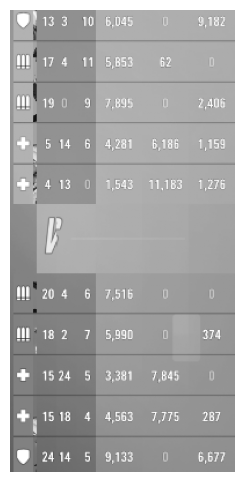

[[   13     3    10  6045     0  9182]
 [   17     4    11  5853    62     0]
 [   19     0     9  7895     0  2406]
 [    5    14     6  4281  6186  1159]
 [    4    13     0  1543 11183  1276]
 [   20     4     6  7516     0     0]
 [   18     2     7  5990     0   374]
 [   15    24     5  3381  7845     0]
 [   15    18     4  4563  7775   287]
 [   24    14     5  9133     0  6677]]


In [19]:
for x_batch, y_batch in val_ds.take(1):
    x_sample = x_batch[0:1]
    y_sample = (array(y_batch).T[0].reshape(-1, num_cols) * max_vals).round().astype(uint16)
    y_pred = model.predict(x_sample)
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(y_sample)

In [36]:
(array(y_pred).squeeze().reshape(-1, num_cols) * max_vals).round().astype('int32')

array([[    6,    11,     6,  2159,  1857,  8340],
       [    6,    -4,     3,  6816,   348,  1836],
       [    6,    -4,     5,  5052,   671, -1052],
       [    7,    13,     6,  2158,  6163,  2719],
       [    6,     3,     4,  1924,  6627,  -720],
       [   10,    13,     4,  2121, -1287,  -219],
       [   21,    10,     2,  1505,   912,  3030],
       [    8,     8,     2,  1970,  2923,  1560],
       [   12,     7,     3,  7140,  1332,  4229],
       [    8,     6,     4,  5270,   527,  8165]], dtype=int32)